In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import data_utils as du
import analog_utils as ana
import graph_utils as gu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

# Data

In [4]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

In [5]:
# import station obsevations and grid point indices
with h5py.File(save_dir+'BCH_ERA5_3H_verif.hdf', 'r') as h5io:
    BCH_obs = h5io['BCH_obs'][...]
    stn_lon = h5io['stn_lon'][...]
    stn_lat = h5io['stn_lat'][...]
    
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
    
with h5py.File(save_dir+'DSCALE_example_2019jan31_d1.hdf', 'r') as h5io:
    lon_4km = h5io['lon_4km'][...]
    lat_4km = h5io['lat_4km'][...]
    dcnn_out = h5io['dcnn_out'][...]
    bcsd_out = h5io['bcsd_out'][...]
    interp_out = h5io['interp_out'][...]
    raw = h5io['raw'][...]

indx, indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)

In [6]:
# dcnn_stn = dcnn_out[indx, indy]
# bcsd_stn = bcsd_out[indx, indy]
# interp_stn = interp_out[indx, indy]

# # subsetting BCH obs into a given year
# year = 2019

# N_days_bch = 366 + 365*3
# date_base_bch = datetime(2016, 1, 1)
# date_list_bch = [date_base_bch + timedelta(days=x) for x in np.arange(N_days_bch, dtype=np.float)]

# flag_pick = []
# for date in date_list_bch:
#     if date.year == year:
#         flag_pick.append(True)
#     else:
#         flag_pick.append(False)

# flag_pick = np.array(flag_pick)

# BCH_obs_ = BCH_obs[flag_pick, ...][30, ...]

# BCH_obs_plot = np.zeros((84,))

# for lead in range(6, 14):
#     BCH_obs_plot += BCH_obs_[lead, :]

# DATA = {}

# DATA['raw'] = raw

# DATA['lon_4km'] = lon_4km
# DATA['lat_4km'] = lat_4km
# DATA['dcnn'] = dcnn_out
# DATA['bcsd'] = bcsd_out
# DATA['interp'] = interp_out

# flag_nan_si = np.logical_not(np.isnan(BCH_obs_plot[flag_si]))
# flag_nan_sw = np.logical_not(np.isnan(BCH_obs_plot[flag_sw]))

# DATA['diff_dcnn_sw'] = BCH_obs_plot[flag_sw][flag_nan_sw] - dcnn_stn[flag_sw][flag_nan_sw]
# DATA['diff_bcsd_sw'] = BCH_obs_plot[flag_sw][flag_nan_sw] - bcsd_stn[flag_sw][flag_nan_sw]
# DATA['diff_interp_sw'] = BCH_obs_plot[flag_sw][flag_nan_sw] - interp_stn[flag_sw][flag_nan_sw]

# DATA['diff_dcnn_si'] = BCH_obs_plot[flag_si][flag_nan_si] - dcnn_stn[flag_si][flag_nan_si]
# DATA['diff_bcsd_si'] = BCH_obs_plot[flag_si][flag_nan_si] - bcsd_stn[flag_si][flag_nan_si]
# DATA['diff_interp_si'] = BCH_obs_plot[flag_si][flag_nan_si] - interp_stn[flag_si][flag_nan_si]

# np.save(save_dir+'DSCALE_example.npy', DATA)

In [7]:
DATA = np.load(save_dir+'DSCALE_example.npy', allow_pickle=True)[()]
keys = ['interp', 'bcsd', 'dcnn']

# Figure

In [8]:
def aspc_cal(edge):
    return (edge[3]-edge[2])/(edge[1]-edge[0])

def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a % b)

# Cartopy map settings
scale_param = '50m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [9]:
def setBoxColors(bp, c, m, lw):
    plt.setp(bp['boxes'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][1], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][0], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][1], color=c, linewidth=lw)
    plt.setp(bp['medians'][0], color=m, linewidth=lw)

In [10]:
edge_bc = [-134-1.5, -114.5-0.5, 48.25, 60]
r_bc = aspc_cal(edge_bc)
cmap_pct, A = gu.precip_cmap()

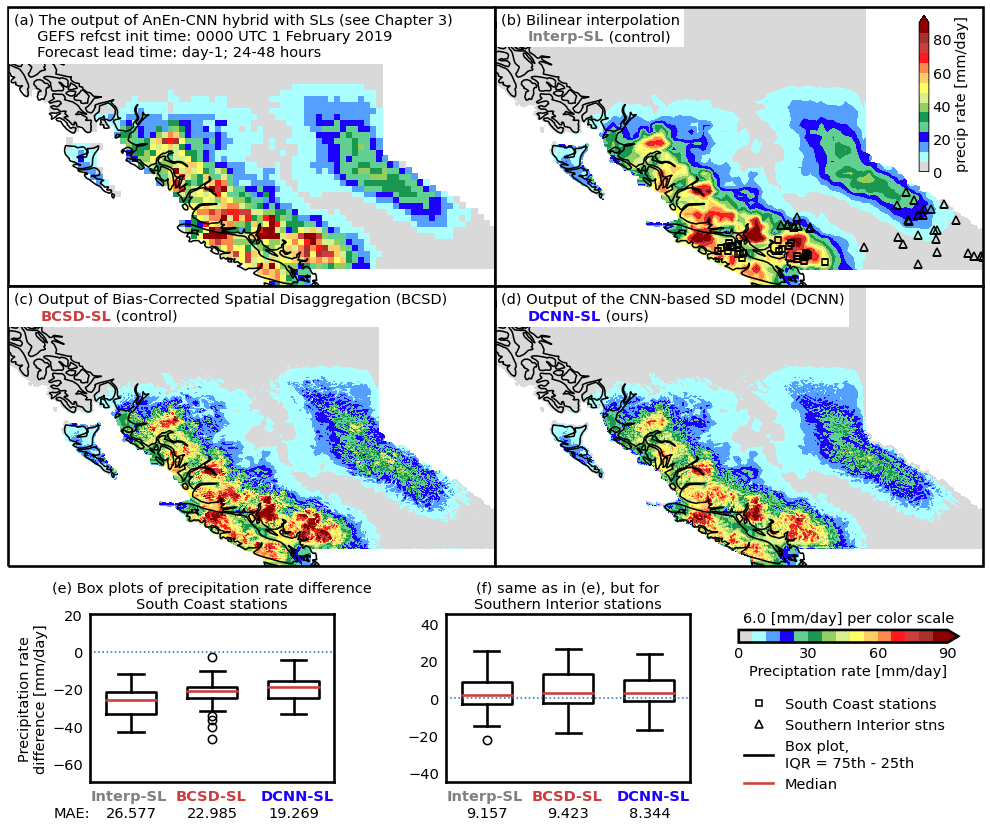

In [11]:
VLIM = [0, 15*6]
hist_bins = np.arange(20, 65, 2)
gray = A[0, :]

fig = plt.figure(figsize=(13, 0.5*3*13*r_bc), dpi=dpi_)
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())

ax_box1 = fig.add_axes([0.085, 0.075, 0.25, 1/5])
ax_box2 = fig.add_axes([0.45, 0.075, 0.25, 1/5])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)
AX = [ax1, ax2, ax3, ax4]
AX_box = [ax_box1, ax_box2]

titles = [
    '(a) The output of AnEn-CNN hybrid with SLs (see Chapter 3)'+
    '\n     GEFS refcst init time: 0000 UTC 1 February 2019'+
    '\n     Forecast lead time: day-1; 24-48 hours', 
    '(b) Bilinear interpolation\n', 
    '(c) Output of Bias-Corrected Spatial Disaggregation (BCSD)\n',
    '(d) Output of the CNN-based SD model (DCNN)\n']

handle_text_title = []
yw = [0.9775]*4
xw = 0.0125
for n, ax in enumerate(AX):
    ax.set_extent(edge_bc, ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=1.5)
    ax.spines['geo'].set_linewidth(2.5)
    handle_text_title.append(ax.text(xw, yw[n], titles[n], ha='left', va='top', 
                                     fontsize=14, transform=ax.transAxes, zorder=3))
handle_subtext = []
handle_subtext += gu.string_partial_format(fig, ax2, 0.01, 0.9185, 'left', 'top', 
                                           ['      ', 'Interp-SL', ' (control)'], 
                                           ['k', '0.5', 'k'], [14,]*3,  ['normal', 'bold', 'normal'])

handle_subtext += gu.string_partial_format(fig, ax3, 0.01, 0.9185, 'left', 'top', 
                                           ['      ', 'BCSD-SL', ' (control)'], 
                                           ['k', red, 'k'], [14,]*3,  ['normal', 'bold', 'normal'])

handle_subtext += gu.string_partial_format(fig, ax4, 0.01, 0.9185, 'left', 'top', 
                                           ['      ', 'DCNN-SL', ' (ours)'], 
                                           ['k', blue, 'k'], [14,]*3,  ['normal', 'bold', 'normal'])
# ========== #
# boxplot part

regions = ['sw', 'si']
dict_c = dict(marker='o', ms=8, mew=1.5, mfc='none')
locy = [-89, -64]
for i, key in enumerate(['interp', 'bcsd', 'dcnn']):
    loc = i + 1.0
    for j, ax in enumerate(AX_box):
        r = regions[j]
        L = len(DATA['diff_{}_{}'.format(key, r)])
        handle_boxp = ax.boxplot(DATA['diff_{}_{}'.format(key, r)], positions=[loc,], flierprops=dict_c, widths=0.618)
        setBoxColors(handle_boxp, 'k', red, 2.5)
        ax.text(loc, locy[j], '{:.3f}'.format(np.mean(np.abs(DATA['diff_{}_{}'.format(key, r)]))), ha='center', fontsize=14)
    
YLIM = [[-70, 20], [-45, 45]]
for i, ax in enumerate([ax_box1, ax_box2]):
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0.5, 3.5])
    ax.set_xticks([1.0, 2.0, 3.0])
    ax.tick_params(labelleft=True, labelbottom=False)
    handle_subtext += gu.string_partial_format(fig, ax, 0.0, -0.045, 'left', 'top', 
                                           ['Interp-SL',], ['0.5',], [14,],  ['bold',])
    handle_subtext += gu.string_partial_format(fig, ax, 0.35, -0.045, 'left', 'top', 
                                           ['BCSD-SL',], [red,], [14,],  ['bold',])
    handle_subtext += gu.string_partial_format(fig, ax, 0.7, -0.045, 'left', 'top', 
                                           ['DCNN-SL',], [blue,], [14,],  ['bold',])

    ax.set_ylim(YLIM[i])
    ax.axhline(0.0, xmin=0, xmax=1.0, linestyle=':', linewidth=1.5)

ax_box1.set_ylabel('Precipitation rate\ndifference [mm/day]', fontsize=14)
ax_box1.set_title('(e) Box plots of precipitation rate difference\nSouth Coast stations', fontsize=14)
ax_box2.set_title('(f) same as in (e), but for\nSouthern Interior stations', fontsize=14)

ax_box1.text(-0.15, -0.2245, 'MAE:', ha='left', va='bottom', fontsize=14, transform=ax_box1.transAxes)

# ========== #

CS = AX[0].pcolormesh(bc_lon, bc_lat, DATA['raw'], vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)

for i, key in enumerate(keys):
    i += 1
    AX[i].pcolormesh(DATA['lon_4km'], DATA['lat_4km'], DATA[key], vmin=VLIM[0], vmax=VLIM[1], cmap=cmap_pct)

# ========== #

handle_sw = ax2.plot(DATA['lon_4km'][indx, indy][flag_sw], 
                     DATA['lat_4km'][indx, indy][flag_sw], 'ks', ms=6.5, mew=1.5, mfc='none')
handle_si = ax2.plot(DATA['lon_4km'][indx, indy][flag_si], 
                     DATA['lat_4km'][indx, indy][flag_si], 'k^', ms=8, mew=1.5, mfc='none')

for handle in handle_text_title:
    handle.set_bbox(dict(facecolor='w', edgecolor='none', zorder=4))

for handle in handle_subtext:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=5))
    
ax_base = fig.add_axes([0.935, 5/6-0.03, 0.02, 1/6+0.02])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='100%', width='50%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='vertical', extend='max', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
CBar.set_label('precip rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)

padx = 0.025
pady = 0.0175

ax_base = fig.add_axes([0.775-padx, 0.244-pady, 0.225, 0.03])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', ticks=[0, 30, 60, 90], extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Preciptation rate [mm/day]', fontsize=14)
CBar.outline.set_linewidth(2.5)

ax_w2 = fig.add_axes([0.775-padx, 0.244+0.03-pady, 0.225, 0.0225])
ax_w2.set_axis_off()
ax_w2.text(0.5, 1, '6.0 [mm/day] per color scale', fontsize=14, 
           ha='center', va='top', transform=ax_w2.transAxes);

ax_lg = fig.add_axes([0.75-padx, 0.075-pady, 0.25, 0.135])
ax_lg.set_axis_off()
LG = ax_lg.legend([handle_sw[0], handle_si[0], 
                   handle_boxp["boxes"][0], handle_boxp["medians"][0]],
                  ["South Coast stations",
                   'Southern Interior stns',
                   'Box plot,\nIQR = 75th - 25th',
                   'Median'], bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})

LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'DSCALE_example.png', format='png', **fig_keys)